In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

import warnings
warnings.filterwarnings("ignore")

# Configura para que os plots sejam exibidos diretamente no notebook
%matplotlib inline

# Avaliação Final dos Modelos

## Obtendo Dados

In [2]:
df_matriz = pd.read_csv('Resultados/modelos_por_metrica.txt', sep = ';', encoding='latin')

In [3]:
pd.options.display.max_rows = 1000

## Funções Auxiliares

In [4]:
def algoritmos():
    nomes = {'xgb': {'nome':'XGB Classifier'},
             'rdf': {'nome':'Random Forest Classifier'},
             'isf': {'nome':'Isolation Forest'},
             'knn': {'nome':'K Nearest KNeighbors'},
             'lof': {'nome':'Local Outlier Factor'}
            }            
    
    return nomes
nomes = algoritmos()

In [5]:
def par_melhor_metrica(dataset, tipo, metrica):
    aux = df_matriz.query('dataset=="'+dataset+'" and metrica== "'+metrica+'" and tipo=="'+tipo+'"').groupby(['parametro','hora_inicio']).valor.max().reset_index().sort_values(by='valor', ascending=False).head(1)
    if aux.shape[0] == 0:
        return aux
    param = aux.iloc[0]['parametro']
    hi = aux.iloc[0]['hora_inicio']
    return  df_matriz.query('dataset=="'+dataset+'" and tipo=="'+tipo+'" and parametro=="'+param+'" and hora_inicio=="'+hi+'"').copy()

def melhor_modelo(dataset='', tipo='', metrica='', unico=False):
    if dataset == '':
        datasets = df_matriz.dataset.unique()
    else:
        datasets = [dataset]
    if tipo == '':
        tipos = nomes.keys() #df_matriz.tipo.unique()
    else:
        tipos = [tipo]        
    if metrica == '':
        metricas = df_matriz.metrica.unique()
    else:
        metricas = [metrica]        

    df_axu = pd.DataFrame(data=None, columns=df_matriz.columns)
    df_axu['melhor'] = ''
    
    for dataset in datasets:
        for tipo in tipos:
            for metrica in metricas:
                # Obter os melhores modelos por dataset, algoritmo e métrica
                aux = par_melhor_metrica(dataset, tipo, metrica)                
                if aux.shape[0] > 0:
                    aux['melhor'] = metrica
                    df_axu = df_axu.append(aux)
    if unico:
        # Retorna os melhores modelos de forma única (métricas desse melhor modelo)
        return (df_axu.pivot_table('valor',['dataset','tipo', 'melhor'], 'metrica', aggfunc='max').style.highlight_max(axis=0))
    else:
        # Retorna os modelos das melhores métricas de forma independente
        return (df_axu.pivot_table('valor',['dataset','tipo'], 'metrica', aggfunc='max').style.highlight_max(axis=0))
        

In [6]:
def matriz_modelos(dataset='', tipo='', metrica=''):
    j = 0
    nome = [dataset, tipo, metrica]
    if dataset == '':
        datasets = df_matriz.dataset.unique()
        nome[2]= 'dataset'
    else:
        datasets = [dataset]
        nome[j] = dataset
        j+=1
        
    if tipo == '':
        tipos = nomes.keys() #df_matriz.tipo.unique()
        nome[2]= 'tipo'
    else:
        tipos = [tipo]
        nome[j] = nomes[tipo]['nome']
        j+=1
        
    if metrica == '':
        metricas = df_matriz.metrica.unique()
        nome[2]= 'metrica'
    else:
        metricas = [metrica]      
        if j < 2:
            nome[j] = metrica
        else:
            nome[2]= 'metrica'


    df_filtro = pd.DataFrame(data=None, columns=df_matriz.columns)
    df_filtro['melhor'] = ''
    
    for dataset in datasets:
        for tipo in tipos:
            for metrica in metricas:
                # Obter os melhores modelos por dataset, algoritmo e métrica
                aux = par_melhor_metrica(dataset, tipo, metrica)                
                aux['melhor'] = metrica
                if aux.shape[0] > 0:
                    df_filtro = df_filtro.append(aux.query('metrica == "' + metrica + '"'))

    texto = '{} - {} \n Normais: {} x Anômalas {}'.format(nome[0], nome[1], df_filtro['normais'].max(), df_filtro['anomalas'].max())
    plt.figure(figsize=(15, 1))
    plt.subplot(1, 1, 1)
    plt.xticks(())
    plt.yticks(())
    plt.text(0.5, 0.5, texto,ha='center', va='center',size=16, alpha=.6)
    
    i = 1
    a = 3 * (int((df_filtro.shape[0]-1)/3)+1) - 1
    linhas = int((df_filtro.shape[0]-1)/3)+1
    colunas = 3
    plt.subplots(linhas, colunas,figsize=(15,a))
    
    for index, row in df_filtro.iterrows():
        if row['metrica'] == row['melhor']:
            plt.subplot(linhas, colunas, i)
            plt.rcParams['figure.figsize'] = (5,3)
            cm1 = pd.DataFrame([[row['TP'], row['FN']], 
                               [row['FP'], row['TN']]])
            ax = sns.heatmap(cm1,fmt='d',
                        xticklabels=['Normais', 'Anômalas'],
                        yticklabels=['Normais', 'Anômalas'],
                        annot=True,
                        linewidths=.2,linecolor="Darkblue", cmap="Blues")
            ax.set(xlabel="Previsto", ylabel = "Real")
            plt.title(row[nome[2]] + " - " + "{:.4}".format(row['valor']), fontsize=12)     
            plt.subplots_adjust(hspace=0.5)
            i+=1
    plt.show()

## Análise dos Modelos

In [7]:
# Valores das métricas dos melhores modelos analisados individualmente
melhor_modelo('Original')

In [8]:
# Valores das métricas dos melhores modelos analisados individualmente
melhor_modelo('SS')

In [9]:
# Valores das métricas dos melhores modelos analisados individualmente
melhor_modelo(tipo='xgb')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,xgb,0.903566,0.941504,0.679061,0.913296,0.802640,0.982416
PT,xgb,0.902890,0.941234,0.676641,0.912767,0.801339,0.982839
RS,xgb,0.903566,0.941504,0.679061,0.913296,0.802640,0.982416
Reduzida,xgb,0.898366,0.938619,0.659152,0.911017,0.794848,0.982247
SS,xgb,0.905254,0.942620,0.684434,0.913009,0.802818,0.982416


In [10]:
# Valores das métricas dos melhores modelos analisados individualmente
melhor_modelo(tipo='rdf')

,metrica,Acurácia,F1,MCC,Precisão,ROC,Recall
dataset,tipo,,,,,,
Original,rdf,0.898703,0.938615,0.663363,0.944501,0.831455,0.980387
PT,rdf,0.897758,0.938124,0.658949,0.915175,0.803184,0.973455
RS,rdf,0.898568,0.938453,0.663314,0.916236,0.805703,0.972525
Reduzida,rdf,0.893504,0.935419,0.643787,0.919213,0.807154,0.965508
SS,rdf,0.898298,0.938440,0.662254,0.916263,0.805278,0.970412


## Matriz de Confusão

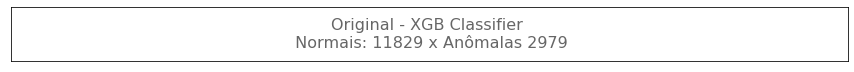

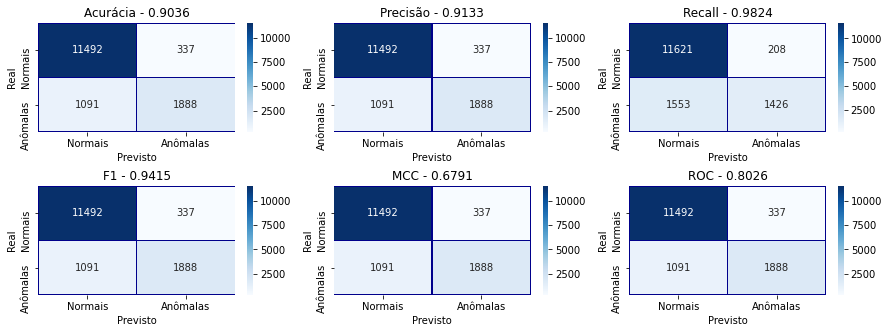

In [11]:
matriz_modelos(dataset='Original', tipo='xgb')

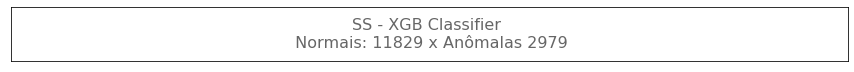

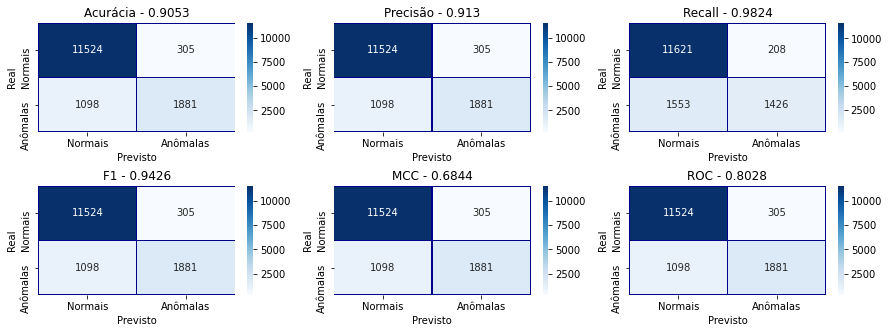

In [12]:
matriz_modelos(dataset='SS', tipo='xgb')

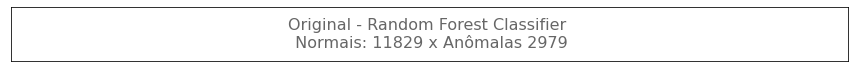

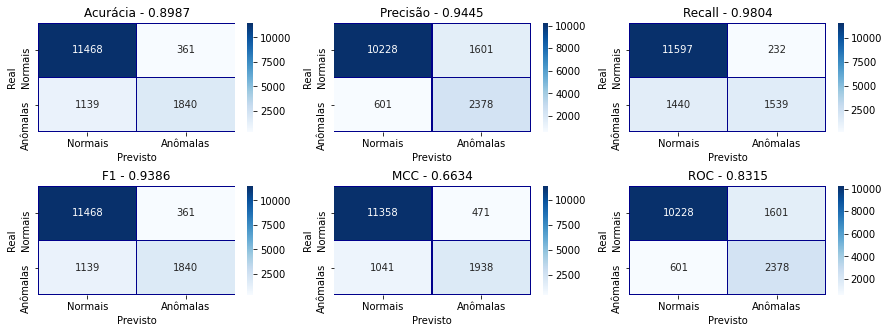

In [13]:
matriz_modelos(dataset='Original', tipo='rdf')

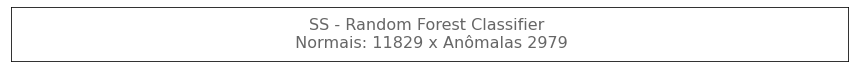

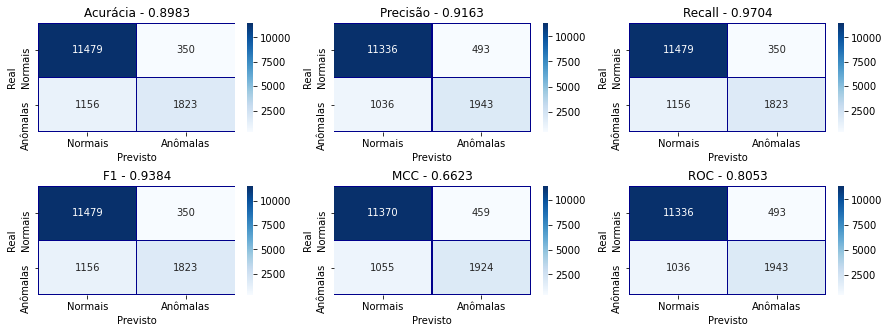

In [14]:
matriz_modelos(dataset='SS', tipo='rdf')

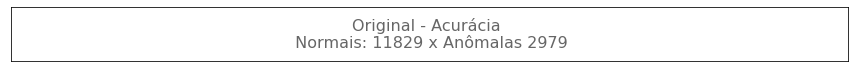

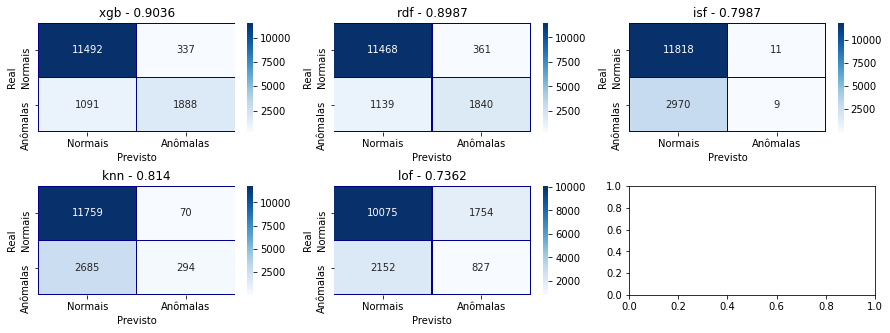

In [15]:
matriz_modelos('Original', metrica='Acurácia')

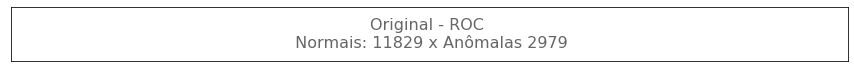

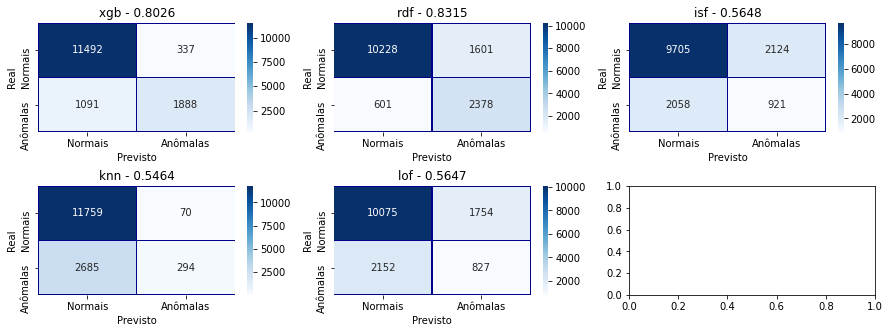

In [16]:
matriz_modelos('Original', metrica='ROC')

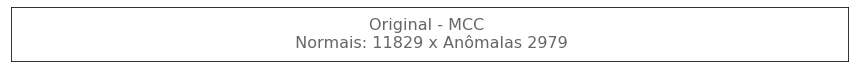

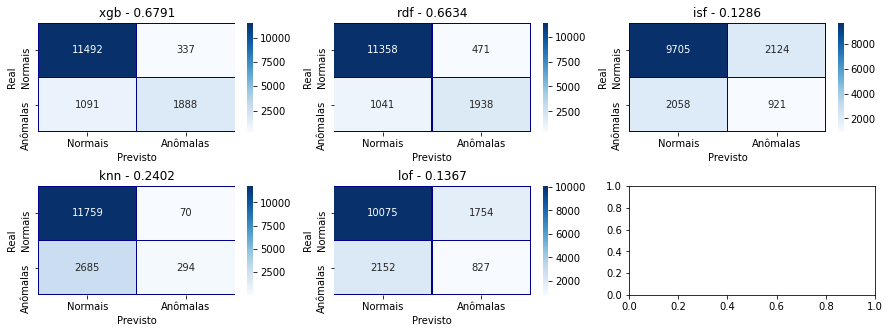

In [17]:
matriz_modelos('Original', metrica='MCC')

## Parâmetros Melhores Modelos

In [18]:
def par_tipo_metrica(dataset, tipo, metrica):
    aux = df_matriz.query('dataset=="'+dataset+'" and metrica== "'+metrica+'" and tipo=="'+tipo+'"').groupby(['parametro','hora_inicio']).valor.max().reset_index().sort_values(by='valor', ascending=False).head(1)
    if aux.shape[0] == 0:
        return aux
    param = aux.iloc[0]['parametro']
    hi = aux.iloc[0]['hora_inicio']
    print('Base: '+dataset+' - Algoritmo: '+tipo+' - Métrica: '+metrica)
    print(param)

In [19]:
par_tipo_metrica('Original', 'xgb', 'MCC')

Base: Original - Algoritmo: xgb - Métrica: MCC
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}


In [20]:
par_tipo_metrica('Original', 'xgb', 'Recall')

Base: Original - Algoritmo: xgb - Métrica: Recall
{'n_estimators': 45, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5}


In [21]:
par_tipo_metrica('SS', 'xgb', 'MCC')

Base: SS - Algoritmo: xgb - Métrica: MCC
{'n_estimators': 99, 'min_child_weight': 3, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 5}


In [22]:
par_tipo_metrica('SS', 'xgb', 'Recall')

Base: SS - Algoritmo: xgb - Métrica: Recall
{'n_estimators': 45, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5}


In [23]:
par_tipo_metrica('Original', 'rdf', 'MCC')

Base: Original - Algoritmo: rdf - Métrica: MCC
{'n_estimators': 300, 'min_samples_split': 7, 'min_impurity_decrease': 1e-05, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}


In [24]:
par_tipo_metrica('Original', 'rdf', 'ROC')

Base: Original - Algoritmo: rdf - Métrica: ROC
{'n_estimators': 400, 'min_samples_split': 7, 'min_impurity_decrease': 0.001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}


In [25]:
par_tipo_metrica('SS', 'rdf', 'MCC')

Base: SS - Algoritmo: rdf - Métrica: MCC
{'n_estimators': 300, 'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}


In [26]:
par_tipo_metrica('SS', 'rdf', 'ROC')

Base: SS - Algoritmo: rdf - Métrica: ROC
{'n_estimators': 300, 'min_samples_split': 7, 'min_impurity_decrease': 0.0001, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
